In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from Bio import SeqIO
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.manifold import trustworthiness
from scipy.stats import pearsonr
from scipy.stats import spearmanr


In [3]:
# add src code to system path
import sys
sys.path.append("src")
from LocalDirichletEnergy import get_local_dirichlet_energy
from Utils import get_representations

/Users/matthewspence/venvs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading cutinase data

In [4]:
# load cutinase data
df = pd.read_csv("data/cutinase_fitness.csv")

In [5]:
# add aligned data to df
aln_seq_ls = [
    str(fasta_seq.seq).upper().rstrip()
    for fasta_seq in SeqIO.parse("./data/cutinase_sequences_ALN.fasta", "fasta")
]
aln_names_ls = [
    str(fasta_seq.id)
    for fasta_seq in SeqIO.parse("./data/cutinase_sequences_ALN.fasta", "fasta")
]
df = df.merge(pd.DataFrame({"Name": aln_names_ls, "Aln_sequence": aln_seq_ls}), on="Name")

In [6]:
name_ls = df["Name"].tolist()
seq_ls = df["Sequence"].tolist()

phases = df.Phase.tolist()
names = df.Name.tolist()

mean = df["Scaled Average Absorbance  (control subtracted)"].to_numpy()
stdev = df["Scaled SD of Mean  (control subtracted)"].to_numpy()
seq_ls = df.Sequence.tolist()
aln_seq_ls = df["Aln_sequence"].tolist()

In [7]:
print(f"Number of sequences: {len(seq_ls)}")

Number of sequences: 196


# Get sequence embeddings

OHE embeddings:

In [8]:
# get ohe embeddings for aligned sequences
aa_ls = [
    'A', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L',
    'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'
]

ohe_dict = {}
for i, aa in enumerate(aa_ls):
    arr_idx = np.zeros((len(aa_ls)))
    arr_idx[i] = 1
    ohe_dict[aa] = arr_idx
ohe_dict["-"] = np.zeros((len(aa_ls)))

In [9]:
ohe_seqs = []
for seq in aln_seq_ls:
    seq_ohe = []
    for aa in seq:
        ohe_aa = ohe_dict[aa]
        seq_ohe.append(ohe_aa)
    ohe_seqs.append(np.array(seq_ohe).flatten())
ohe_seqs = np.array(ohe_seqs)

LASE embeddings:

In [10]:
lase_seqs = get_representations(
    seq_ls,
    Path("models/final_epoch_model.pt"),
    32,
    64,
    2,
    0.1,
    3,
)

/Users/matthewspence/Documents/Documents/cutinase_lase/src/Utils.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path)
/Users/matthew

Prepare for plotting:

In [11]:
print(df.Phase.unique())

['II - ASR' 'V - Alternate Reconstructions' 'I - Extants, Designs, ICCG'
 'IX - Recombinations' 'N205C/S252C']


In [12]:
# palette for phase coloring
phase_palette = {
    'II - ASR': '#4387C7',
    'V - Alternate Reconstructions': '#00B192',
    'I - Extants, Designs, ICCG': '#D35227',
    'IX - Recombinations': '#7F52A1',
    'N205C/S252C': '#456845', 
}

# OHE TSNE

In [13]:
tsne = TSNE(
    random_state=0, 
    perplexity=30, 
    init="random",
    learning_rate=200,
)

res = tsne.fit_transform(ohe_seqs)

x_ohe = res[:, 0]
y_ohe = res[:, 1]

In [15]:
name_ls.index('35_442')

18

3.9541059

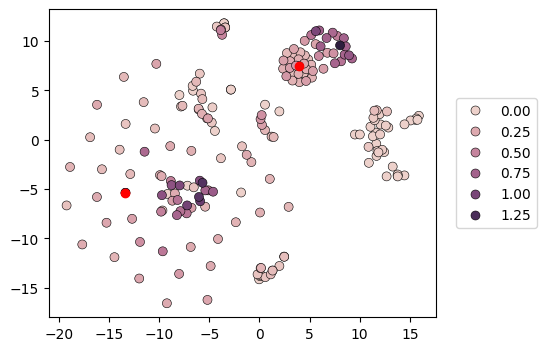

In [19]:
fig, ax = plt.subplots(figsize=(5, 4))
mean_sort = np.argsort(mean)
sns.scatterplot(x=x_ohe[mean_sort], y=y_ohe[mean_sort], hue=mean[mean_sort], s=42, edgecolor="black", linewidth=0.4, ax=ax)
plt.scatter(x=x_ohe[name_ls.index('35_442')], y=y_ohe[name_ls.index('35_442')], color='red')
plt.scatter(x=x_ohe[name_ls.index('55_547')], y=y_ohe[name_ls.index('55_547')], color='red')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)
#plt.savefig("./figures/ohe_activity.pdf", bbox_inches='tight')
plt.show()

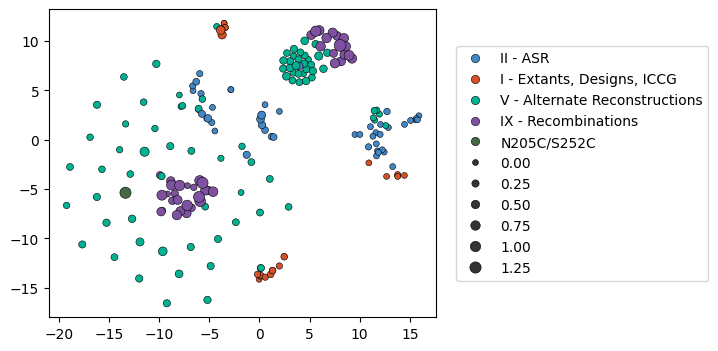

In [14]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(
    x=x_ohe[mean_sort], 
    y=y_ohe[mean_sort], 
    hue=np.array(phases)[mean_sort].tolist(), 
    size=mean[mean_sort], 
    edgecolor="black", linewidth=0.4, ax=ax,
    palette=phase_palette,
)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
#plt.savefig("./figures/ohe_phase.pdf", bbox_inches='tight')
plt.show()

### Trustworthiness of tSNE projection

In [239]:
ohe_trustworthiness = trustworthiness(ohe_seqs,
                                      res)
print(ohe_trustworthiness)

0.9390686061658706


# OHE Local Dirichlet Energy

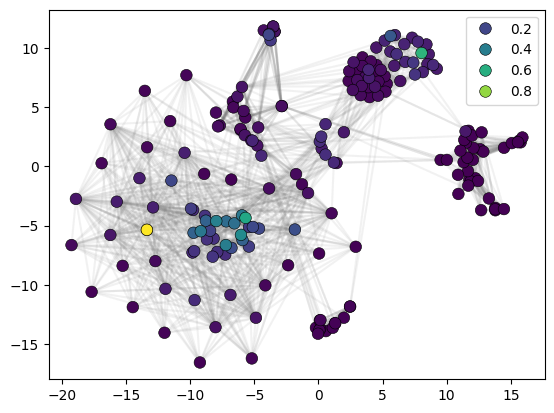

In [15]:
local_ens, local_edge_ls = get_local_dirichlet_energy(ohe_seqs, np.array(mean))

# plot each edge
for i in range(len(local_edge_ls)):
    for idx in local_edge_ls[i][0]:
        plt.plot([x_ohe[i], x_ohe[idx]], [y_ohe[i], y_ohe[idx]], color="grey", alpha=0.05)

local_ens_sort = np.argsort(local_ens)

sns.scatterplot(
    x=x_ohe[local_ens_sort], 
    y=y_ohe[local_ens_sort],
    hue=np.array(local_ens)[local_ens_sort],
    zorder=5,
    palette="viridis",
    s=70,
    edgecolor="black", linewidth=0.4, 
)
#plt.savefig("./figures/ohe_dirichlet_energies.pdf", bbox_inches='tight')
plt.show()

In [16]:
# order of energies and coords
ohe_energy_dict = {
    "Name": [],
    "Phase": [],
    "Fitness": [],
    "Local energy": [],
    "LASE tSNE x": [],
    "LASE tSNE y": []
}
for i in np.flip(local_ens_sort):
    ohe_energy_dict["Name"].append(name_ls[i])
    ohe_energy_dict["Phase"].append(phases[i])
    ohe_energy_dict["Fitness"].append(mean[i])
    ohe_energy_dict["Local energy"].append(np.round(local_ens[i], 4))
    ohe_energy_dict["LASE tSNE x"].append(np.round(x_ohe[i], 4))
    ohe_energy_dict["LASE tSNE y"].append(np.round(y_ohe[i], 4))

pd.DataFrame(ohe_energy_dict).to_csv("./data/OHE_local_dirichlet_energies.csv", index=False)

# LASE TSNE

In [240]:
tsne = TSNE(
    random_state=0, 
    perplexity=30, 
    init="random",
    learning_rate=200,
)

res = tsne.fit_transform(lase_seqs)

x_lase = res[:, 0]
y_lase = res[:, 1]

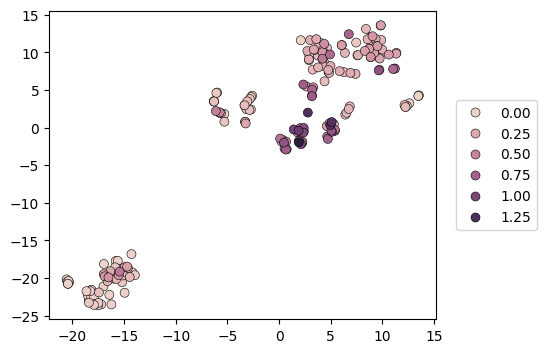

In [241]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(x=x_lase[mean_sort], y=y_lase[mean_sort], hue=mean[mean_sort], s=42, edgecolor="black", linewidth=0.4, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)
#plt.savefig("./figures/lase_activity.pdf", bbox_inches='tight')
plt.show()

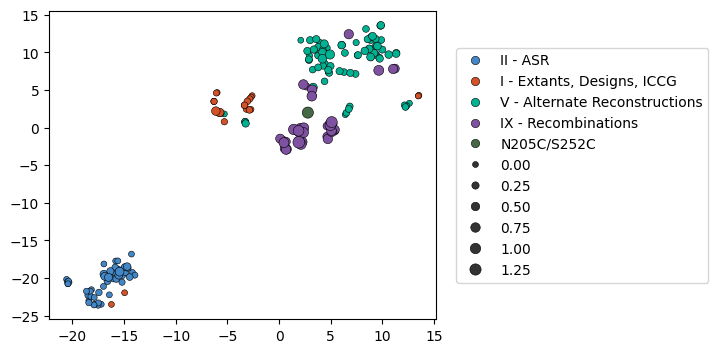

In [242]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(
    x=x_lase[mean_sort], 
    y=y_lase[mean_sort], 
    hue=np.array(phases)[mean_sort].tolist(), 
    size=mean[mean_sort], 
    edgecolor="black", linewidth=0.4, ax=ax,
    palette=phase_palette
    
)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
#plt.savefig("./figures/lase_phase.pdf", bbox_inches='tight')
plt.show()

## Trustworthiness of LASE tSNE projection

In [244]:
lase_trustworthiness = trustworthiness(lase_seqs,
                                      res)
print(lase_trustworthiness)

0.9862082066869301


# Local Dirichlet energy over LASE space

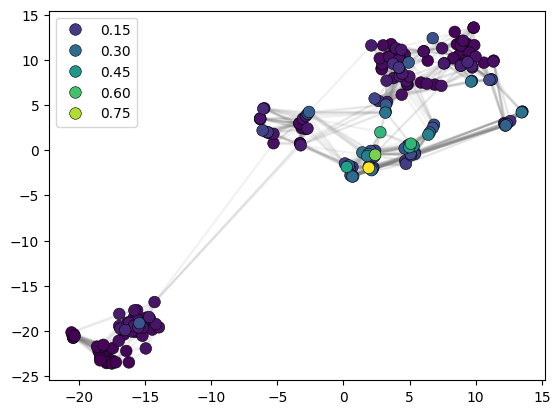

In [20]:
local_ens_lase, local_edge_lase_ls = get_local_dirichlet_energy(lase_seqs, np.array(mean))

# plot each edge
local_ens_sort = np.argsort(local_ens_lase)

for i in range(len(local_edge_lase_ls)):
    for idx in local_edge_lase_ls[i][0]:
        plt.plot([x_lase[i], x_lase[idx]], [y_lase[i], y_lase[idx]], color="grey", alpha=0.05)

sns.scatterplot(
    x=x_lase[local_ens_sort], 
    y=y_lase[local_ens_sort],
    hue=np.array(local_ens_lase)[local_ens_sort],
    zorder=5,
    palette="viridis",
    s=70,
    edgecolor="black", linewidth=0.4, 
)
#plt.savefig("./figures/lase_dirichlet_energies.pdf", bbox_inches='tight')
plt.show()

In [21]:
# order of energies and coords
lase_energy_dict = {
    "Name": [],
    "Phase": [],
    "Fitness": [],
    "Local energy": [],
    "LASE tSNE x": [],
    "LASE tSNE y": []
}
for i in np.flip(local_ens_sort):
    lase_energy_dict["Name"].append(name_ls[i])
    lase_energy_dict["Phase"].append(phases[i])
    lase_energy_dict["Fitness"].append(mean[i])
    lase_energy_dict["Local energy"].append(np.round(local_ens_lase[i], 4))
    lase_energy_dict["LASE tSNE x"].append(np.round(x_lase[i], 4))
    lase_energy_dict["LASE tSNE y"].append(np.round(y_lase[i], 4))

#pd.DataFrame(lase_energy_dict).to_csv("./data/LASE_local_dirichlet_energies.csv", index=False)
df = pd.DataFrame(lase_energy_dict)


## Iterate through `k` values to test sensitivity to graph connectivity.

### LASE

In [215]:
k_dict = {}

k_vals = np.linspace(0.01 * len(df), 0.2 * len(df), 10)
for k in k_vals:
    local_ens_lase, local_edge_lase_ls = get_local_dirichlet_energy(lase_seqs, np.array(mean), k=int(k))
    local_ens_sort = np.argsort(local_ens_lase)
    energy_dict = {}
    
    for i in np.flip(local_ens_sort):
        
        energy_dict[name_ls[i]] = np.round(local_ens_lase[i], 4)
    
    energy_dict = dict(sorted(energy_dict.items()))
    k_dict [int(k)] = energy_dict

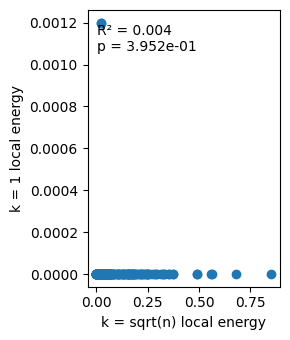

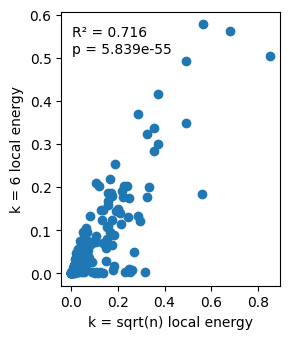

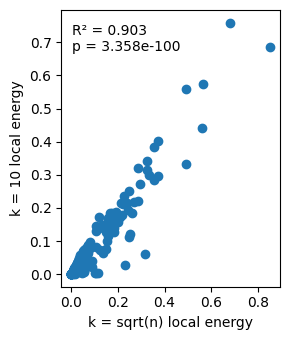

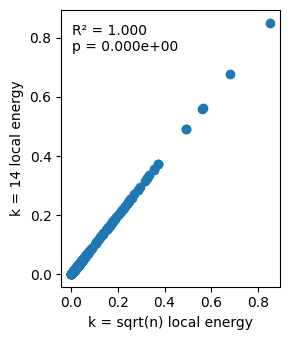

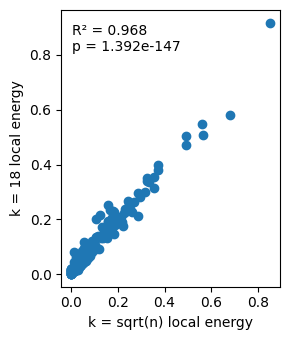

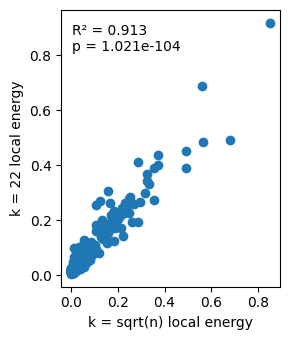

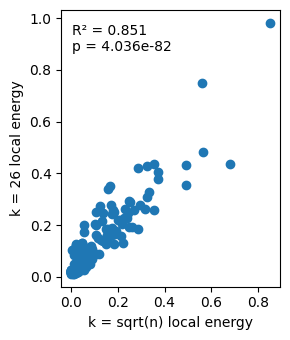

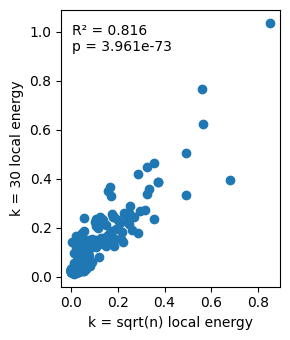

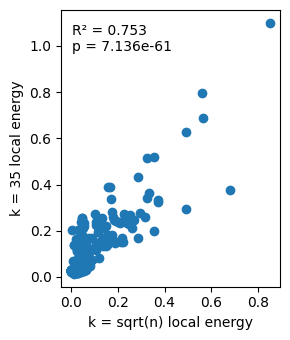

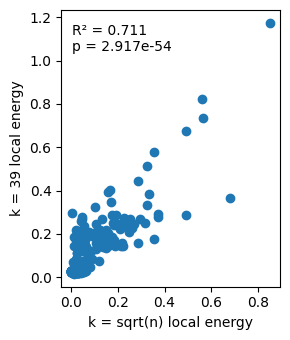

In [216]:
sqrt_energy = lase_energy_dict["Local energy"]
sqrt_name = lase_energy_dict["Name"]
sqrt_energy_dict = {name: local_energy for name, local_energy in zip(sqrt_name, sqrt_energy)}
sqrt_energy_dict = dict(sorted(sqrt_energy_dict.items()))

for key in k_dict.keys():

    x = list(sqrt_energy_dict.values())
    y = list(k_dict[key].values())
    r, p_value = pearsonr(x, y)
    r_squared = r**2

    fig = plt.figure(figsize=(3, 3.5))
    plt.scatter(x, y)
    plt.xlabel('k = sqrt(n) local energy')
    plt.ylabel(f'k = {key} local energy')

    plt.text(
        0.05, 0.95, 
        f'R² = {r_squared:.3f}\np = {p_value:.3e}', 
        transform=plt.gca().transAxes, 
        verticalalignment='top'
    )
    plt.tight_layout()
    plt.savefig(f'figures/k_knn_si_figure/lase_k={key}_scatter.pdf')
    plt.show()


### OHE

In [217]:
k_dict = {}

k_vals = np.linspace(0.01 * len(df), 0.2 * len(df), 10)
for k in k_vals:
    local_ens_ohe, local_edge_sort_ls = get_local_dirichlet_energy(ohe_seqs, np.array(mean), k=int(k))
    local_ens_sort = np.argsort(local_ens_ohe)
    energy_dict = {}
    
    for i in np.flip(local_ens_sort):
        
        energy_dict[name_ls[i]] = np.round(local_ens_ohe[i], 4)
    
    energy_dict = dict(sorted(energy_dict.items()))
    k_dict [int(k)] = energy_dict

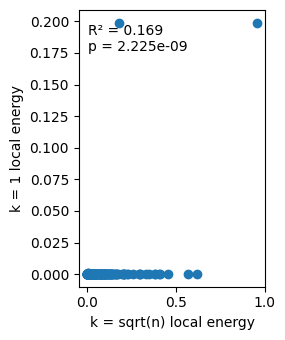

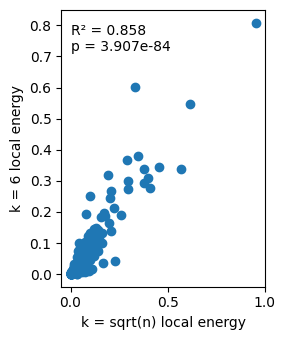

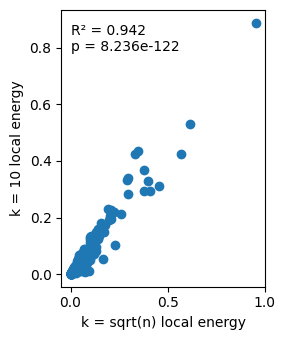

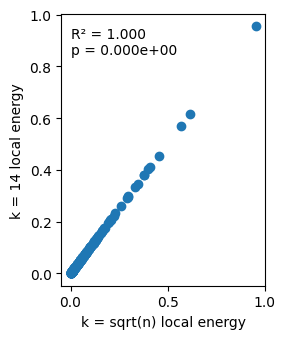

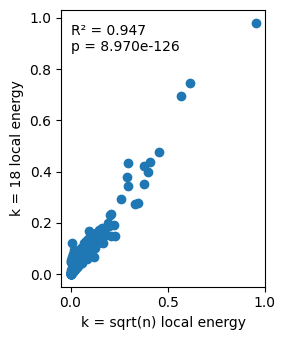

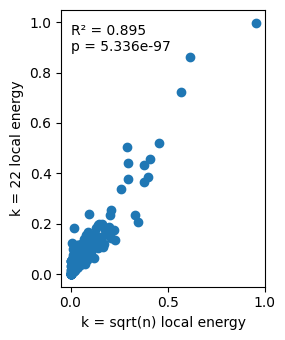

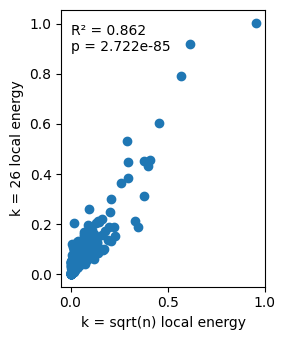

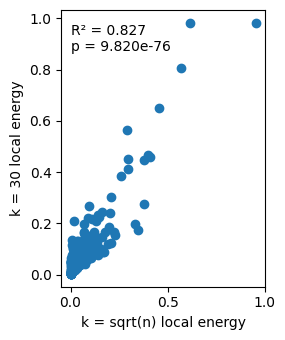

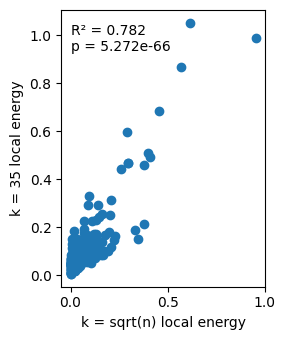

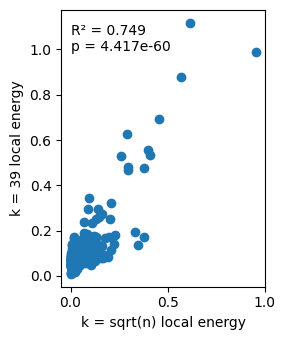

In [218]:
sqrt_energy = ohe_energy_dict["Local energy"]
sqrt_name = ohe_energy_dict["Name"]
sqrt_energy_dict = {name: local_energy for name, local_energy in zip(sqrt_name, sqrt_energy)}
sqrt_energy_dict = dict(sorted(sqrt_energy_dict.items()))

for key in k_dict.keys():

    x = list(sqrt_energy_dict.values())
    y = list(k_dict[key].values())
    r, p_value = pearsonr(x, y)
    r_squared = r**2

    fig = plt.figure(figsize=(3, 3.5))
    plt.scatter(x, y)
    plt.xlabel('k = sqrt(n) local energy')
    plt.ylabel(f'k = {key} local energy')

    plt.text(
        0.05, 0.95, 
        f'R² = {r_squared:.3f}\np = {p_value:.3e}', 
        transform=plt.gca().transAxes, 
        verticalalignment='top'
    )
    plt.tight_layout()
    plt.savefig(f'figures/k_knn_si_figure/ohe_k={key}_scatter.pdf')
    plt.show()

## Iterate through data dropout to test sensitivity to sparsity.

### LASE

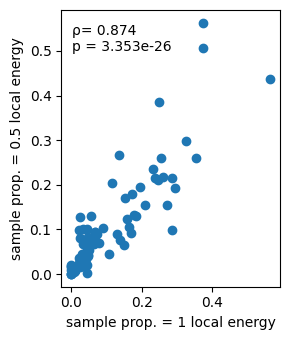

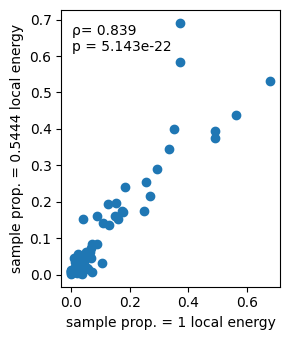

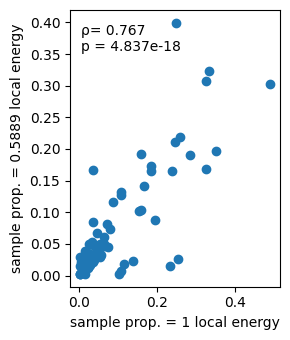

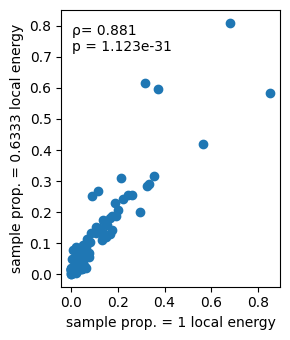

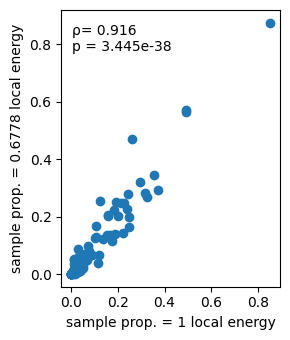

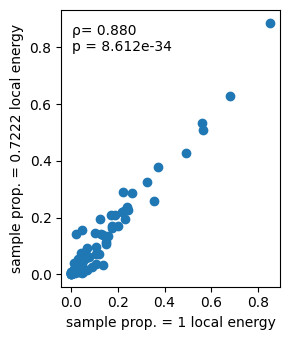

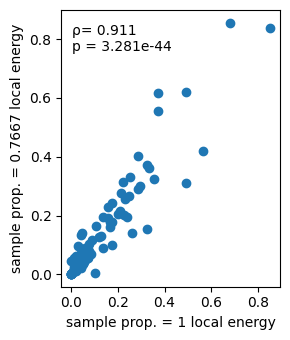

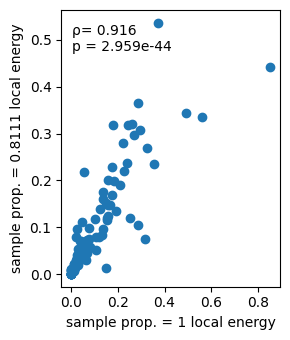

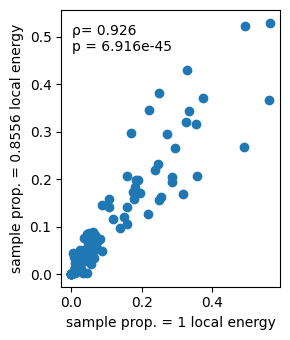

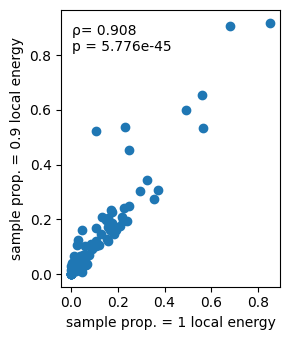

In [213]:

local_ens_lase, local_edge_lase_ls = get_local_dirichlet_energy(lase_seqs, np.array(mean))

ground_truth_sampled_dict = {
    name: energy for name, energy in zip (name_ls, local_ens_lase)
}


min_prop = 0.5
max_prop = 0.9
prop_vals = np.linspace(min_prop, max_prop, 10)

for prop in prop_vals:

    idx = np.random.choice(list(range(len(df))), int((prop)*len(df)))
    local_ens_lase, local_edge_lase_ls = get_local_dirichlet_energy(lase_seqs[idx], np.array(mean[idx]))

    sampled_dict = {
        name_ls[i]: energy for i, energy in zip(idx, local_ens_lase)
    }


    x = []
    y = []

    common_keys = set(sampled_dict.keys()) & set(ground_truth_sampled_dict.keys())

    for key in common_keys:
        x.append(sqrt_energy_dict[key])
        y.append(sampled_dict[key])

    rho, p_value = spearmanr(x, y)

    fig = plt.figure(figsize=(3, 3.5))
    plt.scatter(x, y)
    plt.xlabel('sample prop. = 1 local energy')
    plt.ylabel(f'sample prop. = {np.round(prop, 4)} local energy')

    plt.text(
        0.05, 0.95, 
        f'ρ= {rho:.3f}\np = {p_value:.3e}', 
        transform=plt.gca().transAxes, 
        verticalalignment='top'
    )
    plt.tight_layout()
    plt.savefig(f'figures/k_knn_si_figure/lase_sample_prop={np.round(prop, 4)}_scatter.pdf')
    plt.show()



### OHE

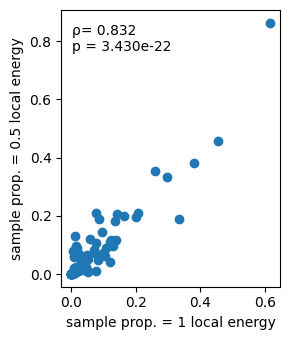

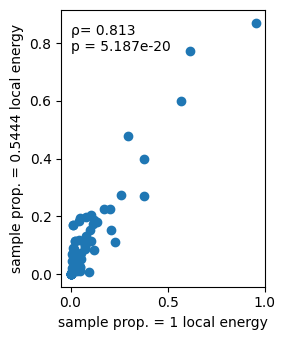

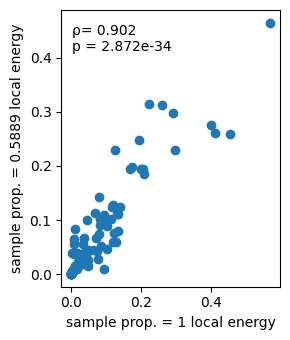

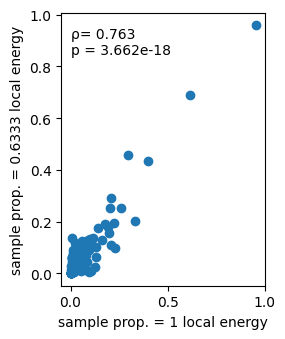

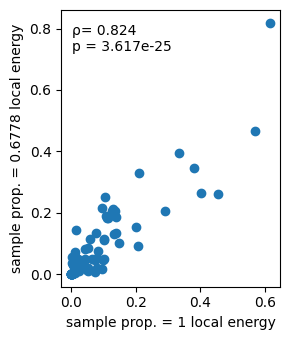

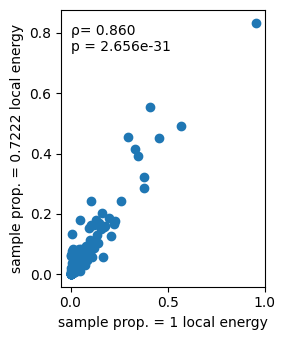

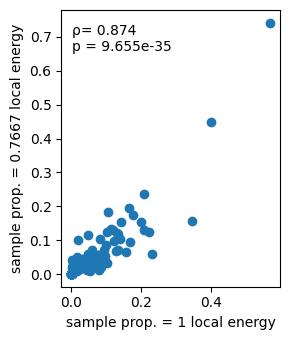

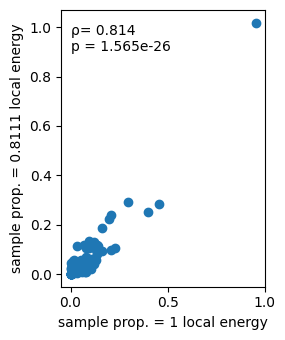

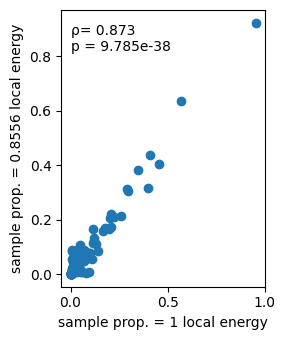

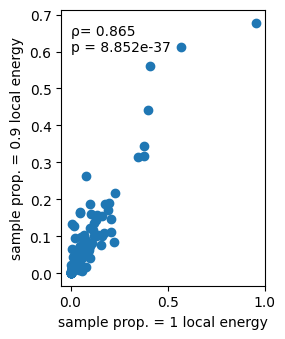

In [219]:

local_ens_ohe, local_edge_ohe_ls = get_local_dirichlet_energy(ohe_seqs, np.array(mean))

ground_truth_sampled_dict = {
    name: energy for name, energy in zip (name_ls, local_ens_ohe)
}


min_prop = 0.5
max_prop = 0.9
prop_vals = np.linspace(min_prop, max_prop, 10)

for prop in prop_vals:

    idx = np.random.choice(list(range(len(df))), int((prop)*len(df)))
    local_ens_ohe, local_edge_ohe_ls = get_local_dirichlet_energy(ohe_seqs[idx], np.array(mean[idx]))

    sampled_dict = {
        name_ls[i]: energy for i, energy in zip(idx, local_ens_ohe)
    }


    x = []
    y = []

    common_keys = set(sampled_dict.keys()) & set(ground_truth_sampled_dict.keys())

    for key in common_keys:
        x.append(sqrt_energy_dict[key])
        y.append(sampled_dict[key])

    rho, p_value = spearmanr(x, y)

    fig = plt.figure(figsize=(3, 3.5))
    plt.scatter(x, y)
    plt.xlabel('sample prop. = 1 local energy')
    plt.ylabel(f'sample prop. = {np.round(prop, 4)} local energy')

    plt.text(
        0.05, 0.95, 
        f'ρ= {rho:.3f}\np = {p_value:.3e}', 
        transform=plt.gca().transAxes, 
        verticalalignment='top'
    )
    plt.tight_layout()
    plt.savefig(f'figures/k_knn_si_figure/ohe_sample_prop={np.round(prop, 4)}_scatter.pdf')
    plt.show()

